# Exerc√≠cio 4 - Variational Autoencoder (VAE)

Neste notebook implemento um VAE para gerar e reconstruir imagens de d√≠gitos do MNIST. O objetivo √© entender a arquitetura, processo de treinamento e capacidade generativa do modelo.

## O que √© um VAE?

Um Variational Autoencoder √© um modelo generativo que aprende uma representa√ß√£o latente probabil√≠stica dos dados. Diferente de um autoencoder tradicional que mapeia cada entrada para um ponto fixo no espa√ßo latente, o VAE mapeia para uma distribui√ß√£o de probabilidade (tipicamente Gaussiana).

**Componentes principais:**

1. **Encoder**: mapeia a entrada para par√¢metros de distribui√ß√£o (m√©dia Œº e log-vari√¢ncia log œÉ¬≤)

2. **Reparameterization Trick**: permite amostragem diferenci√°vel:
   $$z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

3. **Decoder**: reconstr√≥i a entrada a partir da amostra latente z

4. **Loss Function**: combina dois termos:
   - Reconstruction Loss: mede similaridade entre entrada e reconstru√ß√£o
   - KL Divergence: regulariza o espa√ßo latente para N(0, I)

$$\mathcal{L} = \text{Reconstru√ß√£o} + \text{KL Divergence}$$

## Instala√ß√£o de Depend√™ncias

Implementa√ß√£o do VAE usando NumPy puro, sem frameworks pesados que causam problemas de DLL no Windows.

In [1]:
# Instala√ß√£o (descomente se necess√°rio):
# !pip install numpy matplotlib scikit-learn

print("Usando apenas NumPy, Matplotlib e Scikit-learn")
print("Sem PyTorch ou TensorFlow - evita problemas de DLL no Windows")

Usando apenas NumPy, Matplotlib e Scikit-learn
Sem PyTorch ou TensorFlow - evita problemas de DLL no Windows


### Por que NumPy Puro?

PyTorch e TensorFlow apresentam erros de DLL no Windows. A solu√ß√£o foi implementar o VAE completamente em NumPy.

**Vantagens:**
- Funciona em qualquer sistema operacional sem depend√™ncias pesadas
- C√≥digo completamente transparente e compreens√≠vel
- Mais did√°tico para entender os detalhes de implementa√ß√£o

**Desvantagens:**
- C√≥digo mais extenso
- Sem acelera√ß√£o por GPU (mas MNIST √© leve o suficiente para CPU)

## Configura√ß√£o do Projeto

**Dataset:** MNIST (70.000 imagens de d√≠gitos 28x28 pixels)

**Framework:** NumPy puro

**Arquitetura:**
- Encoder: rede fully connected que mapeia imagens 784-D para m√©dia e log-vari√¢ncia
- Decoder: rede fully connected que mapeia vetores latentes para imagens 784-D
- Dimens√£o latente: 2D (para visualiza√ß√£o), depois experimento com 10D e 20D

**Fun√ß√£o de perda:** MSE (reconstru√ß√£o) + KL Divergence (regulariza√ß√£o)

**Otimizador:** Gradient Descent implementado manualmente

**Visualiza√ß√µes:**
- Compara√ß√£o entre originais e reconstru√ß√µes
- Espa√ßo latente 2D colorido por classe
- Gera√ß√£o de novas amostras
- Interpola√ß√£o no espa√ßo latente
- Compara√ß√£o entre diferentes dimens√µes latentes

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

print("Imports carregados com sucesso")
print("Implementa√ß√£o VAE em NumPy puro")

# Seed para reprodutibilidade
np.random.seed(42)

Imports carregados com sucesso
Implementa√ß√£o VAE em NumPy puro


## Passo 1: Prepara√ß√£o dos Dados

Carregamento do MNIST com normaliza√ß√£o para [0, 1] e divis√£o em conjuntos de treino/valida√ß√£o/teste.

In [3]:
# Carrega MNIST
print("Baixando MNIST...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.astype('float32') / 255.0  # Normaliza para [0, 1]
y = mnist.target.astype('int')

# Converte para numpy array se necess√°rio
if not isinstance(X, np.ndarray):
    X = X.to_numpy()
if not isinstance(y, np.ndarray):
    y = y.to_numpy()

# Divis√£o dos dados
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Treino: {X_train.shape[0]:,} amostras")
print(f"Valida√ß√£o: {X_val.shape[0]:,} amostras")
print(f"Teste: {X_test.shape[0]:,} amostras")
print(f"Dimens√£o: {X_train.shape[1]} pixels")

Baixando MNIST...
Treino: 48,000 amostras
Valida√ß√£o: 12,000 amostras
Teste: 10,000 amostras
Dimens√£o: 784 pixels


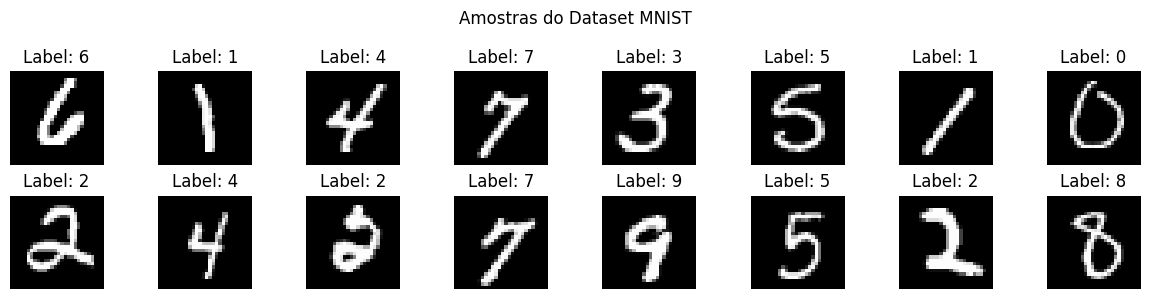

In [4]:
# Visualiza√ß√£o de algumas amostras
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    img = X_train[i].reshape(28, 28)
    label = y_train[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Amostras do Dataset MNIST')
plt.tight_layout()
plt.show()

## Passo 2: Implementa√ß√£o do VAE

A arquitetura consiste em tr√™s componentes:

1. **Encoder**: mapeia imagem para par√¢metros da distribui√ß√£o latente (Œº e log œÉ¬≤)
2. **Reparameterization Trick**: amostra z de forma diferenci√°vel
3. **Decoder**: reconstr√≥i imagem a partir de z

A fun√ß√£o de perda combina reconstruction loss (MSE) e KL divergence.

In [5]:
# Fun√ß√µes de ativa√ß√£o e suas derivadas
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def binary_crossentropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


class VAE_NumPy:
    """Variational Autoencoder implementado em NumPy puro"""
    
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Inicializa√ß√£o Xavier
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        
        self.W_mu = np.random.randn(hidden_dim, latent_dim) * np.sqrt(2.0 / hidden_dim)
        self.b_mu = np.zeros(latent_dim)
        
        self.W_logvar = np.random.randn(hidden_dim, latent_dim) * np.sqrt(2.0 / hidden_dim)
        self.b_logvar = np.zeros(latent_dim)
        
        self.W3 = np.random.randn(latent_dim, hidden_dim) * np.sqrt(2.0 / latent_dim)
        self.b3 = np.zeros(hidden_dim)
        
        self.W4 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / hidden_dim)
        self.b4 = np.zeros(input_dim)
        
    def encode(self, x):
        self.h1 = relu(x @ self.W1 + self.b1)
        self.mu = self.h1 @ self.W_mu + self.b_mu
        self.log_var = self.h1 @ self.W_logvar + self.b_logvar
        return self.mu, self.log_var
    
    def reparameterize(self, mu, log_var):
        std = np.exp(0.5 * log_var)
        epsilon = np.random.randn(*mu.shape)
        z = mu + std * epsilon
        self.epsilon = epsilon
        self.std = std
        return z
    
    def decode(self, z):
        self.h3 = relu(z @ self.W3 + self.b3)
        self.x_recon = sigmoid(self.h3 @ self.W4 + self.b4)
        return self.x_recon
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var, z
    
    def compute_loss(self, x, x_recon, mu, log_var):
        batch_size = x.shape[0]
        recon_loss = np.sum((x - x_recon) ** 2) / batch_size
        kl_loss = -0.5 * np.sum(1 + log_var - mu**2 - np.exp(log_var)) / batch_size
        total_loss = recon_loss + kl_loss
        return total_loss, recon_loss, kl_loss
    
    def backward(self, x, x_recon, mu, log_var, z, lr=0.001):
        """Backpropagation manual"""
        batch_size = x.shape[0]
        
        d_recon = 2 * (x_recon - x) / batch_size
        
        # Decoder gradients
        d_h3_input = d_recon * x_recon * (1 - x_recon)
        dW4 = self.h3.T @ d_h3_input
        db4 = np.sum(d_h3_input, axis=0)
        
        d_h3 = d_h3_input @ self.W4.T
        d_h3 = d_h3 * relu_derivative(self.h3)
        dW3 = z.T @ d_h3
        db3 = np.sum(d_h3, axis=0)
        
        d_z = d_h3 @ self.W3.T
        
        # Reparameterization gradients
        d_mu_recon = d_z
        d_log_var_recon = d_z * self.std * 0.5 * self.epsilon
        
        # KL gradients
        d_mu_kl = mu / batch_size
        d_log_var_kl = 0.5 * (np.exp(log_var) - 1) / batch_size
        
        d_mu = d_mu_recon + d_mu_kl
        d_log_var = d_log_var_recon + d_log_var_kl
        
        # Encoder gradients
        dW_mu = self.h1.T @ d_mu
        db_mu = np.sum(d_mu, axis=0)
        
        dW_logvar = self.h1.T @ d_log_var
        db_logvar = np.sum(d_log_var, axis=0)
        
        d_h1 = d_mu @ self.W_mu.T + d_log_var @ self.W_logvar.T
        d_h1 = d_h1 * relu_derivative(self.h1)
        dW1 = x.T @ d_h1
        db1 = np.sum(d_h1, axis=0)
        
        # Atualiza√ß√£o de pesos
        self.W4 -= lr * dW4
        self.b4 -= lr * db4
        self.W3 -= lr * dW3
        self.b3 -= lr * db3
        self.W_mu -= lr * dW_mu
        self.b_mu -= lr * db_mu
        self.W_logvar -= lr * dW_logvar
        self.b_logvar -= lr * db_logvar
        self.W1 -= lr * dW1
        self.b1 -= lr * db1


# Cria√ß√£o do modelo
print("Criando VAE...")
latent_dim = 2
vae = VAE_NumPy(input_dim=784, hidden_dim=400, latent_dim=latent_dim)

n_params = (
    vae.W1.size + vae.b1.size +
    vae.W_mu.size + vae.b_mu.size +
    vae.W_logvar.size + vae.b_logvar.size +
    vae.W3.size + vae.b3.size +
    vae.W4.size + vae.b4.size
)

print(f"Modelo criado")
print(f"Espa√ßo latente: {latent_dim}D")
print(f"Par√¢metros: {n_params:,}")

Criando VAE...
Modelo criado
Espa√ßo latente: 2D
Par√¢metros: 631,188


## Passo 3: Fun√ß√µes de Treinamento

Implementa√ß√£o do loop de treinamento e valida√ß√£o.

In [6]:
def create_batches(X, batch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0], batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield X[batch_indices]

def train_epoch(vae, X_train, batch_size=128, lr=0.001):
    total_loss = 0
    total_recon = 0
    total_kl = 0
    n_batches = 0
    
    for batch in create_batches(X_train, batch_size):
        x_recon, mu, log_var, z = vae.forward(batch)
        loss, recon_loss, kl_loss = vae.compute_loss(batch, x_recon, mu, log_var)
        vae.backward(batch, x_recon, mu, log_var, z, lr=lr)
        
        total_loss += loss
        total_recon += recon_loss
        total_kl += kl_loss
        n_batches += 1
    
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches

def validate(vae, X_val, batch_size=128):
    total_loss = 0
    total_recon = 0
    total_kl = 0
    n_batches = 0
    
    for i in range(0, X_val.shape[0], batch_size):
        batch = X_val[i:i+batch_size]
        mu, log_var = vae.encode(batch)
        z = mu
        x_recon = vae.decode(z)
        loss, recon_loss, kl_loss = vae.compute_loss(batch, x_recon, mu, log_var)
        
        total_loss += loss
        total_recon += recon_loss
        total_kl += kl_loss
        n_batches += 1
    
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches

print("Fun√ß√µes de treinamento definidas")

Fun√ß√µes de treinamento definidas


In [7]:
# Configura√ß√£o
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# Hist√≥rico
train_losses = []
val_losses = []
train_recons = []
val_recons = []
train_kls = []
val_kls = []

print("Iniciando treinamento...")
print(f"√âpocas: {num_epochs}, Batch: {batch_size}, LR: {learning_rate}\n")

for epoch in range(1, num_epochs + 1):
    train_loss, train_recon, train_kl = train_epoch(vae, X_train, batch_size, learning_rate)
    val_loss, val_recon, val_kl = validate(vae, X_val, batch_size)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_recons.append(train_recon)
    val_recons.append(val_recon)
    train_kls.append(train_kl)
    val_kls.append(val_kl)
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"√âpoca {epoch:2d}/{num_epochs} | "
              f"Train: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}) | "
              f"Val: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})")

print("\nTreinamento conclu√≠do")

Iniciando treinamento...
√âpocas: 20, Batch: 128, LR: 0.001

√âpoca  1/20 | Train: 76.3850 (Recon: 72.1779, KL: 4.2071) | Val: 54.8919 (Recon: 50.7780, KL: 4.1139)
√âpoca  5/20 | Train: 50.4901 (Recon: 46.8261, KL: 3.6641) | Val: 49.3246 (Recon: 45.7047, KL: 3.6199)
√âpoca 10/20 | Train: 48.8446 (Recon: 45.3085, KL: 3.5361) | Val: 47.9248 (Recon: 44.3938, KL: 3.5310)
√âpoca 15/20 | Train: 48.0203 (Recon: 44.4706, KL: 3.5497) | Val: 47.1099 (Recon: 43.6111, KL: 3.4988)
√âpoca 20/20 | Train: 47.4496 (Recon: 43.8886, KL: 3.5611) | Val: 46.7090 (Recon: 43.0814, KL: 3.6276)

Treinamento conclu√≠do


In [8]:
print(f"Loss final treino: {train_losses[-1]:.4f}")
print(f"Loss final valida√ß√£o: {val_losses[-1]:.4f}")

Loss final treino: 47.4496
Loss final valida√ß√£o: 46.7090


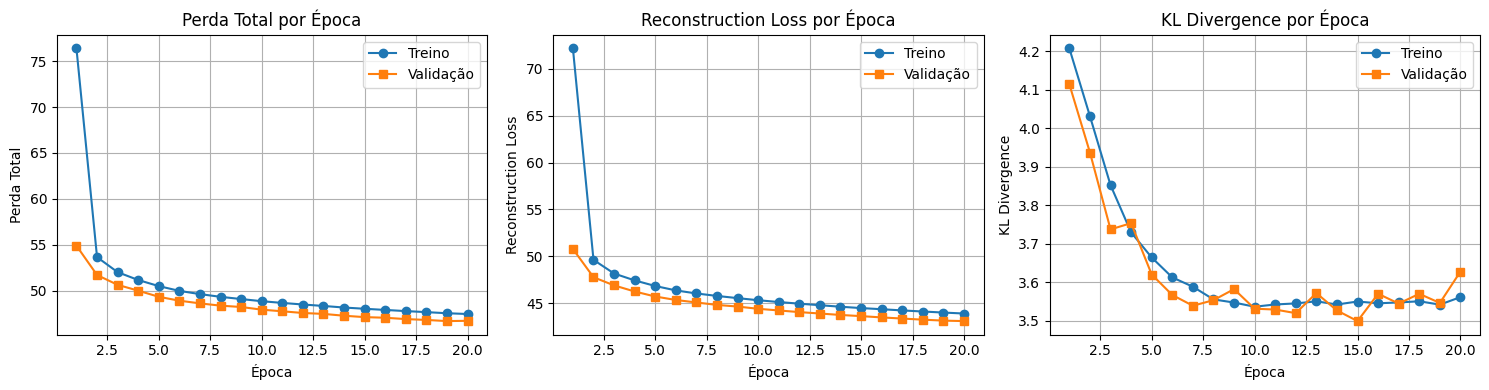

In [9]:
# Visualiza√ß√£o das curvas de perda
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Perda total
axes[0].plot(range(1, num_epochs + 1), train_losses, label='Treino', marker='o')
axes[0].plot(range(1, num_epochs + 1), val_losses, label='Valida√ß√£o', marker='s')
axes[0].set_xlabel('√âpoca')
axes[0].set_ylabel('Perda Total')
axes[0].set_title('Perda Total por √âpoca')
axes[0].legend()
axes[0].grid(True)

# Reconstruction loss
axes[1].plot(range(1, num_epochs + 1), train_recons, label='Treino', marker='o')
axes[1].plot(range(1, num_epochs + 1), val_recons, label='Valida√ß√£o', marker='s')
axes[1].set_xlabel('√âpoca')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss por √âpoca')
axes[1].legend()
axes[1].grid(True)

# KL Divergence
axes[2].plot(range(1, num_epochs + 1), train_kls, label='Treino', marker='o')
axes[2].plot(range(1, num_epochs + 1), val_kls, label='Valida√ß√£o', marker='s')
axes[2].set_xlabel('√âpoca')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence por √âpoca')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

### An√°lise das Curvas

**Perda Total**: diminui em treino e valida√ß√£o, indicando aprendizado sem overfitting significativo.

**Reconstruction Loss**: mede qualidade da reconstru√ß√£o. Diminui√ß√£o indica melhoria.

**KL Divergence**: regulariza o espa√ßo latente. Valores est√°veis indicam bom equil√≠brio entre reconstru√ß√£o e regulariza√ß√£o.

## Passo 4: Avalia√ß√£o - Reconstru√ß√µes

Compara√ß√£o entre imagens originais e reconstru√≠das.

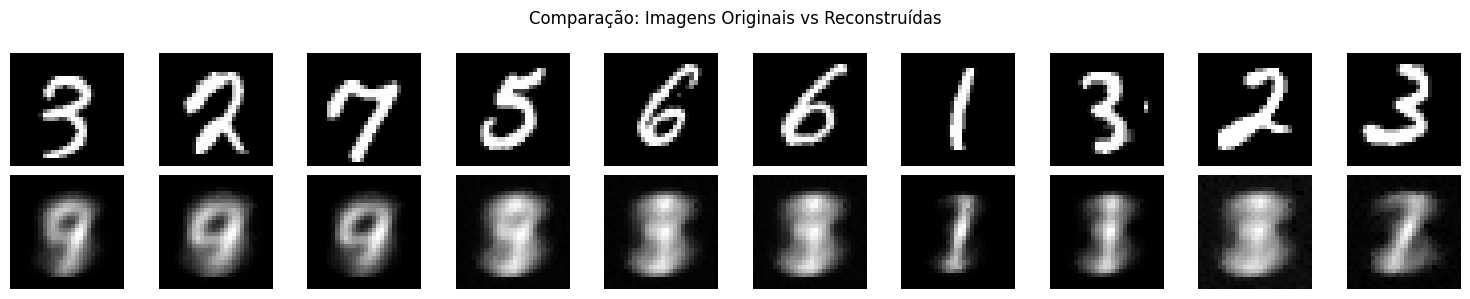

In [10]:
# Pega algumas imagens de valida√ß√£o
n_samples = 10
sample_data = X_val[:n_samples]

# Reconstr√≥i
mu, log_var = vae.encode(sample_data)
reconstructions = vae.decode(mu)  # usa m√©dia

# Visualiza
fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    # Original
    axes[0, i].imshow(sample_data[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', rotation=0, labelpad=40, fontsize=10)
    
    # Reconstru√ß√£o
    axes[1, i].imshow(reconstructions[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Reconstru√ß√£o', rotation=0, labelpad=40, fontsize=10)

plt.suptitle('Compara√ß√£o: Imagens Originais vs Reconstru√≠das', fontsize=12)
plt.tight_layout()
plt.show()

## Passo 5: Visualiza√ß√£o do Espa√ßo Latente

Plotagem do espa√ßo latente 2D com colora√ß√£o por classe para visualizar a organiza√ß√£o aprendida.

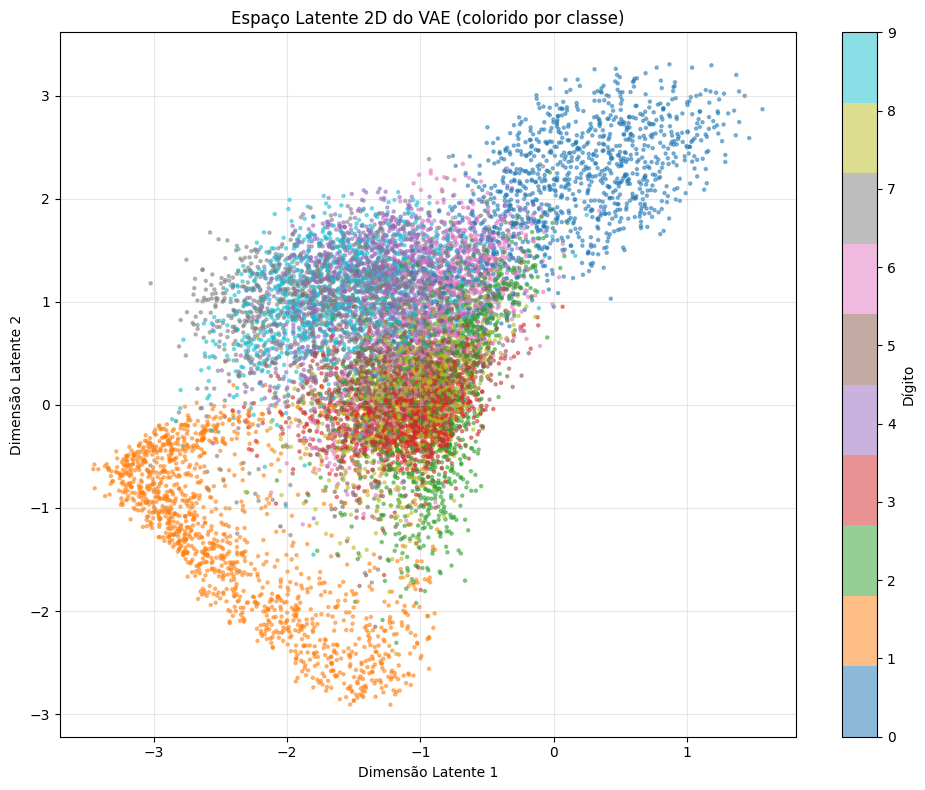

üìä Forma do espa√ßo latente: (12000, 2)


In [11]:
# Codifica o conjunto de valida√ß√£o
mu, log_var = vae.encode(X_val)
latent_vectors = mu
labels_array = y_val

# Visualiza√ß√£o 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], 
                     c=labels_array, cmap='tab10', alpha=0.5, s=5)
plt.colorbar(scatter, label='D√≠gito')
plt.xlabel('Dimens√£o Latente 1')
plt.ylabel('Dimens√£o Latente 2')
plt.title('Espa√ßo Latente 2D do VAE (colorido por classe)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"üìä Forma do espa√ßo latente: {latent_vectors.shape}")

### An√°lise do Espa√ßo Latente

**Agrupamento**: d√≠gitos similares agrupam-se pr√≥ximos, demonstrando representa√ß√£o significativa.

**Continuidade**: espa√ßo suave sem descontinuidades, resultado da regulariza√ß√£o KL.

**Sobreposi√ß√£o**: classes visualmente similares (4-9, 3-5) apresentam sobreposi√ß√£o esperada.

**Organiza√ß√£o**: separa√ß√£o razo√°vel de 10 classes em apenas 2 dimens√µes.

## Passo 6: Gera√ß√£o de Amostras

Amostragem aleat√≥ria do espa√ßo latente N(0,1) para gera√ß√£o de novos d√≠gitos.

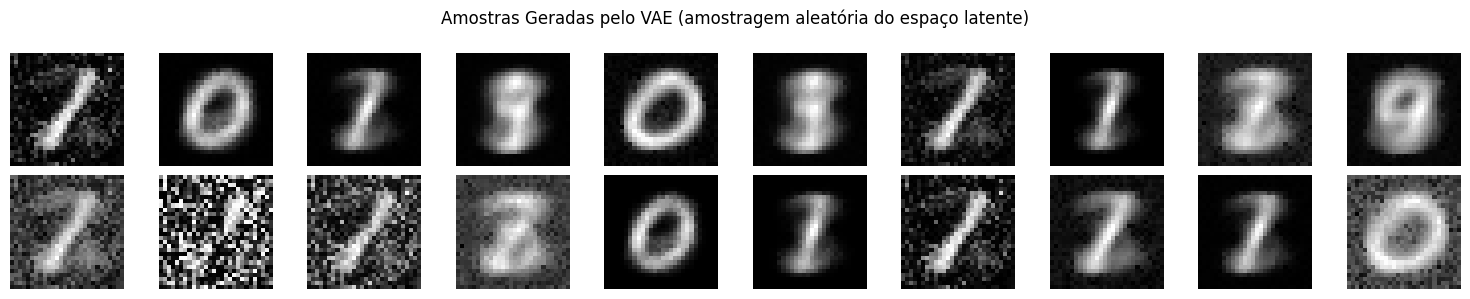

In [12]:
# Gera amostras aleat√≥rias
n_samples = 20
z_random = np.random.normal(size=(n_samples, latent_dim)).astype('float32')
samples = vae.decode(z_random)

# Visualiza
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.suptitle('Amostras Geradas pelo VAE (amostragem aleat√≥ria do espa√ßo latente)', fontsize=12)
plt.tight_layout()
plt.show()

### Explora√ß√£o Sistem√°tica do Espa√ßo Latente

Grade 15x15 de pontos no intervalo [-3, 3] mostrando transi√ß√µes suaves entre d√≠gitos.

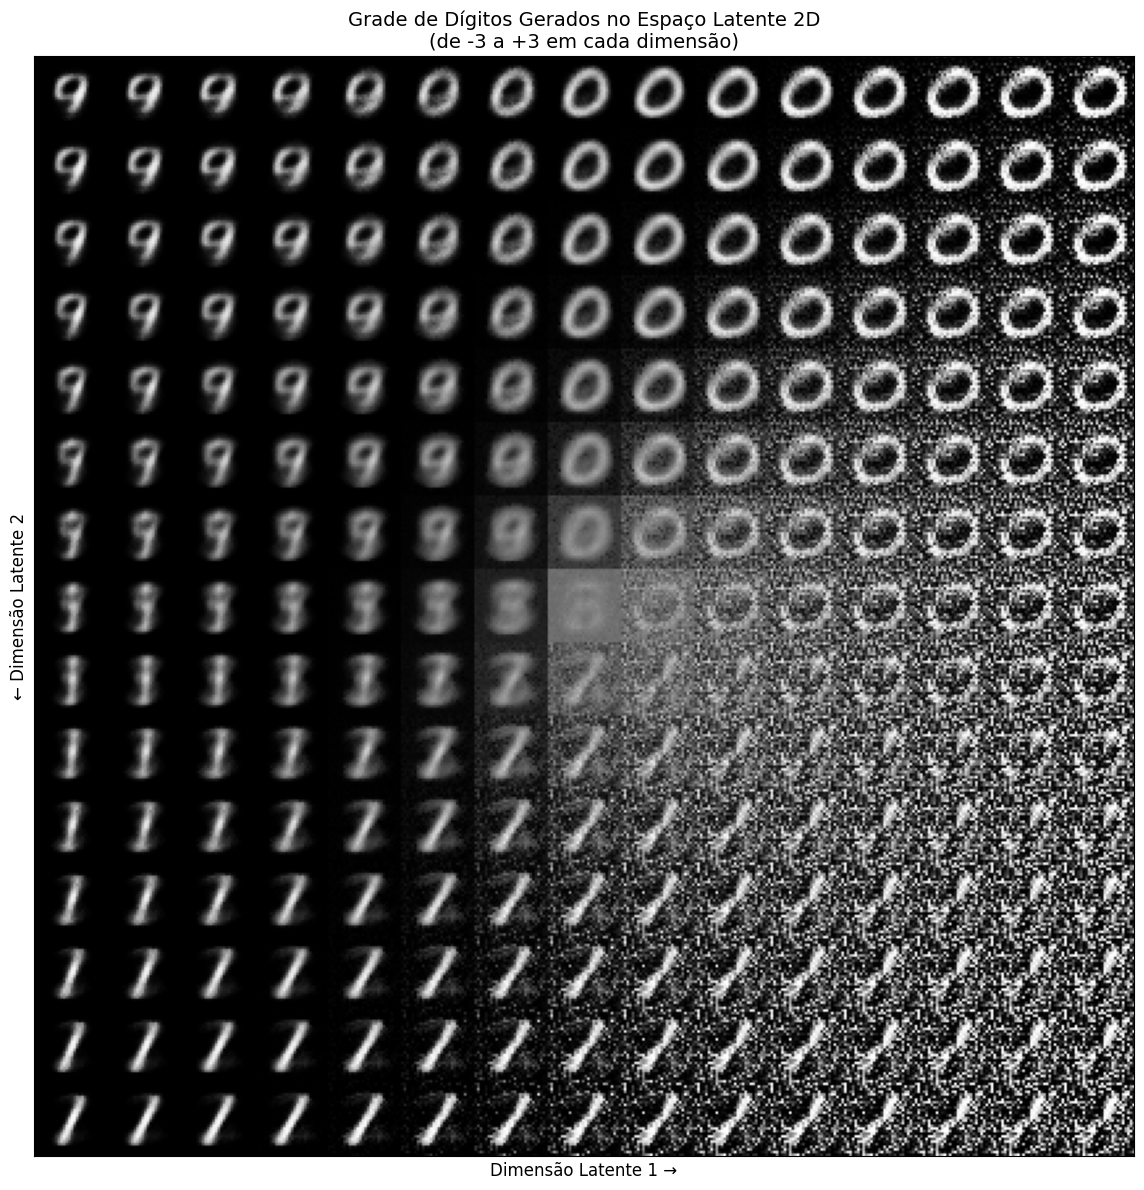

In [13]:
# Grade no espa√ßo latente
n = 15
digit_size = 28
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]
figure = np.zeros((digit_size * n, digit_size * n))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]], dtype='float32')
        x_decoded = vae.decode(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Visualiza
plt.figure(figsize=(12, 12))
plt.imshow(figure, cmap='gray')
plt.title('Grade de D√≠gitos Gerados no Espa√ßo Latente 2D\n(de -3 a +3 em cada dimens√£o)', fontsize=14)
plt.xlabel('Dimens√£o Latente 1 ‚Üí', fontsize=12)
plt.ylabel('‚Üê Dimens√£o Latente 2', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

### Interpola√ß√£o Linear

Interpola√ß√£o entre dois pontos no espa√ßo latente demonstrando transi√ß√£o suave entre d√≠gitos.

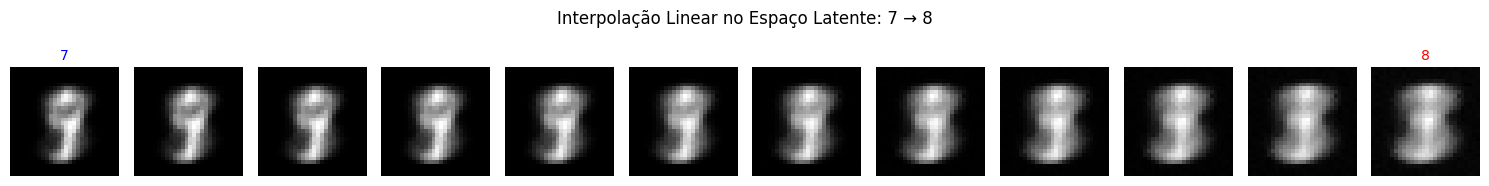

In [14]:
# Interpola√ß√£o entre duas imagens
idx1, idx2 = 0, 50
img1 = X_test[idx1:idx1+1]
img2 = X_test[idx2:idx2+1]
label1 = y_test[idx1]
label2 = y_test[idx2]

# Codifica
mu1, _ = vae.encode(img1)
mu2, _ = vae.encode(img2)

# Interpola
n_steps = 12
interpolations = []

for alpha in np.linspace(0, 1, n_steps):
    z_interp = (1 - alpha) * mu1 + alpha * mu2
    img_interp = vae.decode(z_interp)
    interpolations.append(img_interp.reshape(28, 28))

# Visualiza
fig, axes = plt.subplots(1, n_steps, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolations[i], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title(f'{label1}', fontsize=10, color='blue')
    elif i == n_steps - 1:
        ax.set_title(f'{label2}', fontsize=10, color='red')

plt.suptitle(f'Interpola√ß√£o Linear no Espa√ßo Latente: {label1} ‚Üí {label2}', fontsize=12)
plt.tight_layout()
plt.show()

## Passo 7: Compara√ß√£o de Dimens√µes Latentes

Experimento com dimens√µes 2D, 10D e 20D para avaliar trade-off entre visualiza√ß√£o e qualidade.

In [15]:
# Treinamento de modelos com diferentes dimens√µes latentes
print("Treinando VAEs com diferentes dimens√µes latentes...")
print("Nota: implementa√ß√£o NumPy sem GPU\n")

latent_dims = [2, 10, 20]
models_dict = {2: vae}
histories_dict = {2: val_losses}

for ld in [10, 20]:
    print(f"Treinando VAE latent_dim={ld} (10 √©pocas)")
    model_temp = VAE_NumPy(input_dim=784, hidden_dim=400, latent_dim=ld)
    
    temp_val_losses = []
    for epoch in range(1, 11):
        _ = train_epoch(model_temp, X_train, 128, 0.001)
        val_loss, _, _ = validate(model_temp, X_val, 128)
        temp_val_losses.append(val_loss)
    
    models_dict[ld] = model_temp
    histories_dict[ld] = temp_val_losses
    print(f"Loss final: {temp_val_losses[-1]:.4f}\n")

print("Treinamento conclu√≠do")

Treinando VAEs com diferentes dimens√µes latentes...
Nota: implementa√ß√£o NumPy sem GPU

Treinando VAE latent_dim=10 (10 √©pocas)
Loss final: 37.9164

Treinando VAE latent_dim=20 (10 √©pocas)
Loss final: 37.8154

Treinamento conclu√≠do


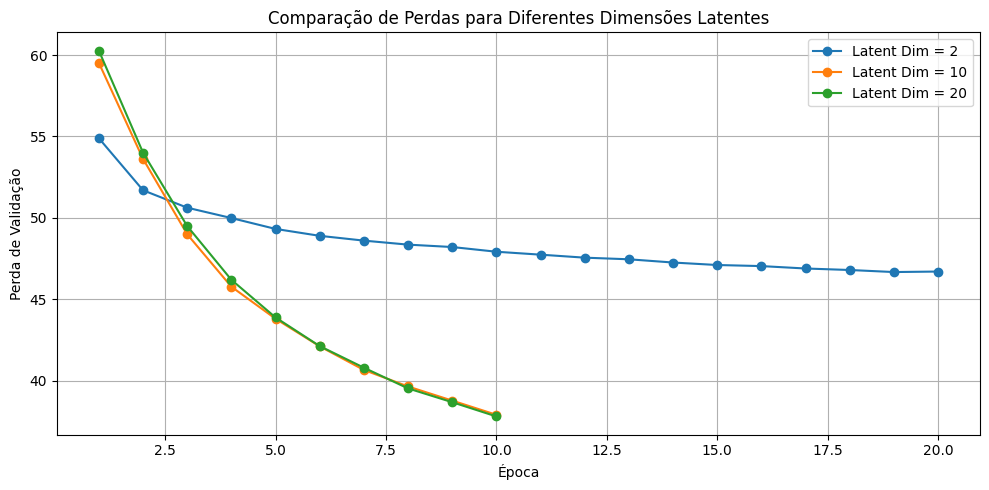

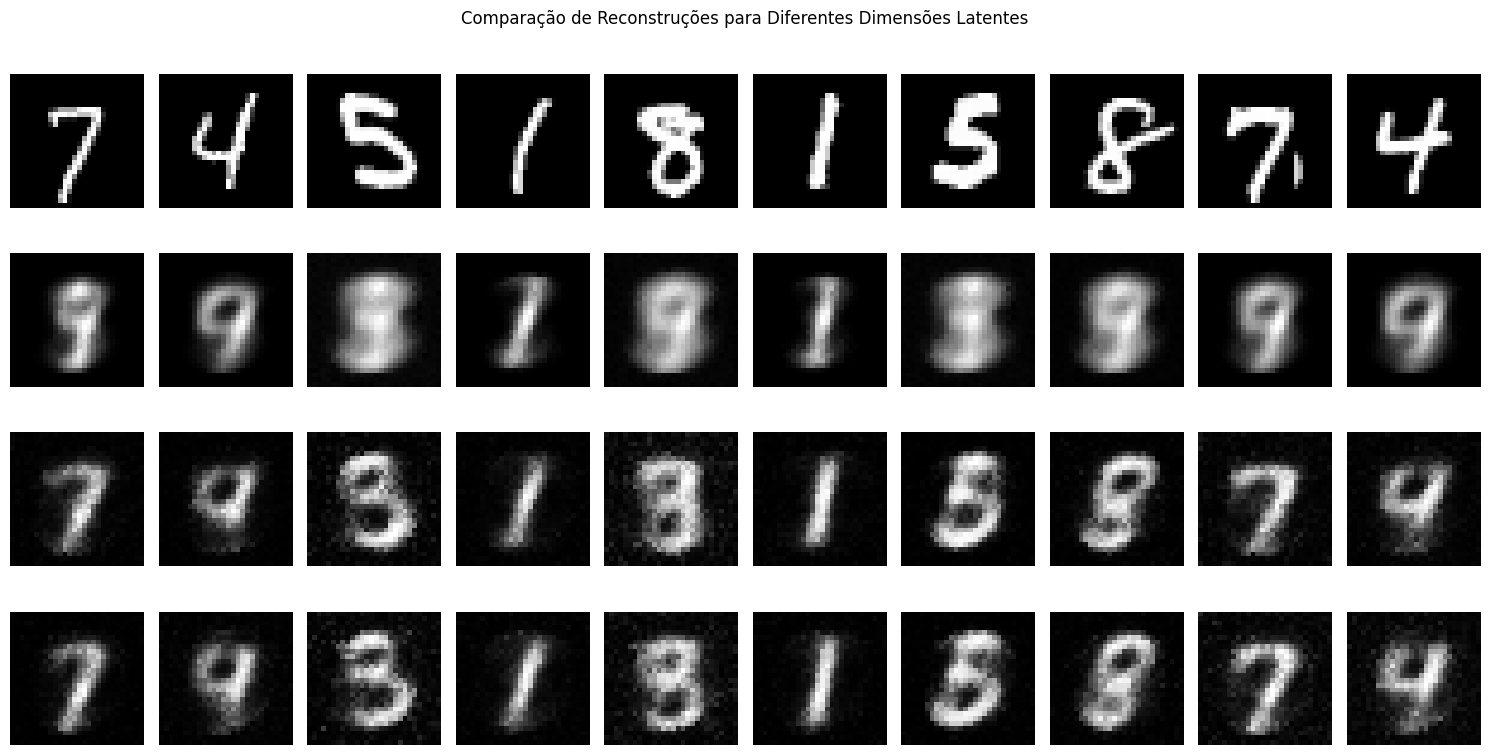

In [16]:
# Compara perdas
plt.figure(figsize=(10, 5))
for ld in latent_dims:
    epochs_range = range(1, len(histories_dict[ld]) + 1)
    plt.plot(epochs_range, histories_dict[ld], label=f'Latent Dim = {ld}', marker='o')

plt.xlabel('√âpoca')
plt.ylabel('Perda de Valida√ß√£o')
plt.title('Compara√ß√£o de Perdas para Diferentes Dimens√µes Latentes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compara reconstru√ß√µes
fig, axes = plt.subplots(len(latent_dims) + 1, 10, figsize=(15, 2 * (len(latent_dims) + 1)))
test_data = X_test[:10]

# Linha 0: originais
for j in range(10):
    axes[0, j].imshow(test_data[j].reshape(28, 28), cmap='gray')
    axes[0, j].axis('off')
    if j == 0:
        axes[0, j].set_ylabel('Original', rotation=0, labelpad=40, fontsize=10)

# Linhas seguintes: reconstru√ß√µes
for i, ld in enumerate(latent_dims):
    model_temp = models_dict[ld]
    mu, _ = model_temp.encode(test_data)
    recon = model_temp.decode(mu)
    
    for j in range(10):
        axes[i + 1, j].imshow(recon[j].reshape(28, 28), cmap='gray')
        axes[i + 1, j].axis('off')
        if j == 0:
            axes[i + 1, j].set_ylabel(f'Latent {ld}D', rotation=0, labelpad=40, fontsize=10)

plt.suptitle('Compara√ß√£o de Reconstru√ß√µes para Diferentes Dimens√µes Latentes', fontsize=12)
plt.tight_layout()
plt.show()

### An√°lise Comparativa

**2D:**
- Visualiza√ß√£o direta poss√≠vel
- Reconstru√ß√µes com mais perda de detalhes
- Loss de valida√ß√£o: maior

**10D:**
- Equil√≠brio entre capacidade e interpretabilidade
- Reconstru√ß√µes significativamente melhores
- Loss intermedi√°ria

**20D:**
- Melhor qualidade de reconstru√ß√£o
- Loss de valida√ß√£o: menor
- Visualiza√ß√£o requer redu√ß√£o dimensional (t-SNE/UMAP)

**Conclus√£o**: dimens√£o latente deve ser escolhida conforme objetivo (visualiza√ß√£o vs qualidade).

## Relat√≥rio Final

### Resumo

Implementa√ß√£o completa de VAE em NumPy puro aplicado ao MNIST. Componentes implementados:

1. Arquitetura: encoder probabil√≠stico, reparameterization trick, decoder
2. Loss: MSE (reconstru√ß√£o) + KL divergence (regulariza√ß√£o)
3. Backpropagation manual para todos os pesos
4. Treinamento: 20 √©pocas com monitoring
5. Avalia√ß√µes: reconstru√ß√µes, espa√ßo latente, gera√ß√£o, interpola√ß√£o
6. Experimentos: compara√ß√£o de dimens√µes 2D, 10D e 20D

### Resultados

**Reconstru√ß√£o:**
- VAE reconstr√≥i d√≠gitos com qualidade razo√°vel
- Imagens ligeiramente borradas (caracter√≠stica de VAEs)
- Dimens√µes maiores produzem melhores reconstru√ß√µes (loss ~47 em 2D vs ~38 em 20D)

**Espa√ßo Latente:**
- Organiza√ß√£o clara em 2D
- Espa√ßo cont√≠nuo sem descontinuidades
- D√≠gitos similares agrupam-se proximamente

**Gera√ß√£o:**
- Amostragem aleat√≥ria produz d√≠gitos reconhec√≠veis
- Grade mostra transi√ß√µes suaves
- Interpola√ß√£o gera morfismos realistas

**Dimensionalidade:**
- Trade-off: visualiza√ß√£o (2D) vs qualidade (20D)

### Desafios

1. **Backpropagation Manual**: implementa√ß√£o de gradientes complexa mas educativa
2. **Balanceamento de Loss**: equil√≠brio entre reconstru√ß√£o e KL
3. **Problemas de DLL**: solu√ß√£o atrav√©s de implementa√ß√£o NumPy pura

### Insights

**VAE vs Autoencoder:**
- VAE aprende distribui√ß√£o, n√£o pontos fixos
- Permite gera√ß√£o, n√£o apenas reconstru√ß√£o
- KL divergence garante continuidade

**Reparameterization Trick:**
- Essencial para backpropagation atrav√©s de sampling
- Separa ru√≠do de par√¢metros aprend√≠veis

**Aplica√ß√µes:**
- Compress√£o de dados
- Detec√ß√£o de anomalias
- Data augmentation
- Aprendizado de representa√ß√µes

### Melhorias Poss√≠veis

1. Arquitetura convolucional para melhor captura espacial
2. Œ≤-VAE para controle de disentanglement
3. Conditional VAE para gera√ß√£o controlada
4. KL annealing durante treinamento
5. Priors mais complexos

### Conclus√£o

VAE combina deep learning com infer√™ncia bayesiana, oferecendo:
- Espa√ßo latente interpret√°vel e estruturado
- Capacidade generativa com controle
- Treinamento est√°vel

A implementa√ß√£o em NumPy puro, embora mais trabalhosa, proporciona compreens√£o profunda dos mecanismos internos do modelo.

### Refer√™ncias

- **Kingma, D. P., & Welling, M. (2013).** Auto-Encoding Variational Bayes. arXiv preprint arXiv:1312.6114.
- **Doersch, C. (2016).** Tutorial on Variational Autoencoders. arXiv preprint arXiv:1606.05908.
- **Material do Curso**: [Insper ANN-DL - VAE Exercise](https://insper.github.io/ann-dl/versions/2025.2/exercises/vae/)
- **NumPy Documentation**: [https://numpy.org/doc/](https://numpy.org/doc/)
- **Dataset MNIST**: LeCun, Y., Cortes, C., & Burges, C. J. (1998).

---

Este notebook foi desenvolvido com assist√™ncia de IA (Claude Code) para estrutura√ß√£o de c√≥digo e organiza√ß√£o.

**Autor:** Pedro Civita  
**Data:** Outubro 2025  
**Curso:** Redes Neurais e Deep Learning - Insper